In [1]:
# Predicting House Price: Regression example

from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
#Preparing the data

def normalize (data):
    mean = data.mean(axis=0)
    std = data.std(axis = 0)
    nrml_mean = data-mean
    nrml_data = nrml_mean/std
    
    return nrml_data

In [5]:
train_data_nrm = normalize(train_data)
test_data_nrm = normalize(test_data)

In [7]:
from keras import models
from keras import layers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data_nrm.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [10]:
#k-fold validation
import numpy as np
k = 4
num_val_samples = len(train_data_nrm) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data_nrm[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data_nrm = np.concatenate(
        [train_data_nrm[:i * num_val_samples],
         train_data_nrm[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

model = build_model()
model.fit(partial_train_data_nrm, partial_train_targets,
          epochs=num_epochs, batch_size=1, verbose=0)
val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [17]:
val_mae

2.4392178058624268

In [19]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data_nrm[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data_nrm[:i * num_val_samples],
                                         train_data_nrm[(i + 1) * num_val_samples:]],
                                        axis=0)

partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                        train_targets[(i + 1) * num_val_samples:]],
                                       axis=0)
model = build_model()
history = model.fit(partial_train_data, 
                    partial_train_targets,validation_data=(val_data, val_targets),
                    epochs=num_epochs, batch_size=1, verbose=0)

history
#mae_history = history.history['val_mean_absolute_error']
#all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [22]:
mae_history = history.history['val_mae']
all_mae_histories.append(mae_history)

In [23]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

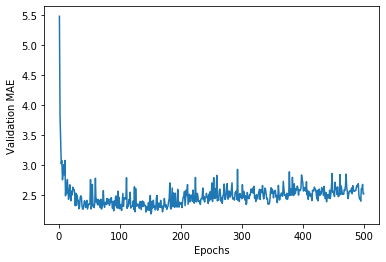

In [26]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()



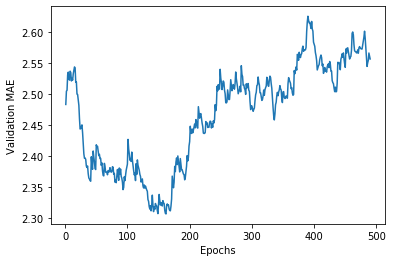

In [33]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [30]:
smooth_mae_history

[5.4832563400268555]

In [34]:
model = build_model()
model.fit(train_data, train_targets,
epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 26.2926 - mae: 3.6363


In [35]:
test_mae_score

3.636282444000244

In [ ]:
"""
1. Regression is done using different loss functions than what we used for classification.
Mean squared error (MSE) is a loss function commonly used for regression.
2. Similarly, evaluation metrics to be used for regression differ from those used for
classification; naturally, the concept of accuracy doesn’t apply for regression. A
common regression metric is mean absolute error (MAE).
3. When features in the input data have values in different ranges, each feature
should be scaled independently as a preprocessing step.
4. When there is little data available, using K-fold validation is a great way to reliably
evaluate a model.
5. When little training data is available, it’s preferable to use a small network with
few hidden layers (typically only one or two), in order to avoid severe overfitting.